In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from spire.doc import *
from spire.doc.common import *
from IPython.display import Image
from PIL import Image as PILImage
from typing import Counter

In [2]:
from FuncionesMineria import(
    analizar_variables_categoricas,
    cuentaDistintos, 
    frec_variables_num, 
    atipicosAmissing, 
    patron_perdidos,
    ImputacionCuant,
    ImputacionCuali,
    Vcramer,
    hist_targetbinaria,
    lm_stepwise,
    lm_backward,
    lm_forward,
    Rsq,
    crear_data_modelo,
    validacion_cruzada_lm,
    modelEffectSizes,
    glm_backward,
    glm_forward,
    glm_stepwise,
    pseudoR2,
    validacion_cruzada_glm,
    sensEspCorte
)

<h2> 2 - Preparacion de Datos </h2>

<h3>Extraccion de datos</h3>

In [3]:
datos = pd.read_excel("../Statement/DatosEleccionesEspaña.xlsx")

<h3>Asignar tipo de datos correctos</h3>

In [4]:
# Asignar tipo de datos correctos

colsFromFloatToInt = ["totalEmpresas", "Industria", "Construccion", "ComercTTEHosteleria", "Servicios", "inmuebles", "Pob2010", "PersonasInmueble"]
colsFromIntToBool = ["Izquierda", "Derecha", "AbstencionAlta"]

for c in colsFromFloatToInt:
    datos[c] = datos[c].fillna(-1)
    datos[c] = datos[c].astype(int)

for c in colsFromFloatToInt:
    datos[c] = datos[c].replace(-1, np.nan)

for c in colsFromIntToBool:
    datos[c] = datos[c].astype(bool)

<h3>3 - Analisis Descriptivo </h3>

In [5]:
print(analizar_variables_categoricas(datos))
print(cuentaDistintos(datos))
print(datos.describe().T)

{'Name':                    n         %
Mieres             2  0.000246
Cieza              2  0.000246
Moya               2  0.000246
Rebollar           2  0.000246
Villaescusa        2  0.000246
...               ..       ...
Muras              1  0.000123
Monterroso         1  0.000123
Monforte de Lemos  1  0.000123
Mondoñedo          1  0.000123
Zuñeda             1  0.000123

[8100 rows x 2 columns], 'CCAA':                    n         %
CastillaLeón    2248  0.276950
Cataluña         947  0.116669
CastillaMancha   919  0.113219
Andalucía        773  0.095232
Aragón           731  0.090058
ComValenciana    542  0.066773
Extremadura      387  0.047678
Galicia          314  0.038684
Navarra          272  0.033510
PaísVasco        251  0.030923
Madrid           179  0.022052
Rioja            174  0.021436
Cantabria        102  0.012566
Canarias          88  0.010841
Asturias          78  0.009609
Baleares          67  0.008254
Murcia            45  0.005544, 'AbstencionAlta':         

In [6]:
datos[datos.columns].isna().sum()

Name                              0
CodigoProvincia                   0
CCAA                              0
Population                        0
TotalCensus                       0
AbstentionPtge                    0
AbstencionAlta                    0
Izda_Pct                          0
Dcha_Pct                          0
Otros_Pct                         0
Izquierda                         0
Derecha                           0
Age_0-4_Ptge                      0
Age_under19_Ptge                  0
Age_19_65_pct                     0
Age_over65_pct                    0
WomanPopulationPtge               0
ForeignersPtge                    0
SameComAutonPtge                  0
SameComAutonDiffProvPtge          0
DifComAutonPtge                   0
UnemployLess25_Ptge               0
Unemploy25_40_Ptge                0
UnemployMore40_Ptge               0
AgricultureUnemploymentPtge       0
IndustryUnemploymentPtge          0
ConstructionUnemploymentPtge      0
ServicesUnemploymentPtge    

<h2>4 - Corrección de los errores detectados. </h2>
<h3>Tratamiento de datos incorrectos </h3>

In [7]:
categoricas = ["Densidad", "Population", "Name", "CCAA"]

for c in categoricas:
    datos[c] = datos[c].replace('nan',np.nan)

datos["Densidad"] = datos["Densidad"].replace('?', np.nan)

Vamos a tratar a las variables que representan porcentajes para poner como valor perdido cualquier observacion por fuera del rango de un porcentaje (0-100) la unica excepcion es la variable "PobChange_pct" ya que explicitamente esta explicado que los valores negativos aportan informacion

In [8]:
porcentajes = [
    "WomanPopulationPtge", "ForeignersPtge", "SameComAutonPtge", "SameComAutonDiffProvPtge", "DifComAutonPtge",
    "UnemployLess25_Ptge", "Unemploy25_40_Ptge", "UnemployMore40_Ptge", "AgricultureUnemploymentPtge", "IndustryUnemploymentPtge",
    "ConstructionUnemploymentPtge", "ServicesUnemploymentPtge", "AbstentionPtge", "Izda_Pct", "Dcha_Pct", "Otros_Pct", "Age_0-4_Ptge",
    "Age_under19_Ptge", "Age_19_65_pct", "Age_over65_pct"]

for c in porcentajes:
    datos[c] = [x if 0 <= x <= 100 else np.nan for x in datos[c]]

In [9]:

datos["ActividadPpal"] = datos["ActividadPpal"].replace(["Otro"], "Otros")


<h3>Eliminar variables objetivo y codificadora</h3>

<ul>
    <li>Izda Pct: Porcentaje de votos a partidos de izquierda (PSOE y Podemos) </li>
    <li>Izquierda: Variable dicotómica que toma el valor 1 si la suma de los votos de izquierdas es superior a la de derechas y otros y, 0, en otro caso. </li>
</ul>

In [10]:
varObjIzdaPct = datos["Izda_Pct"]
varObjIzquierda = datos["Izquierda"]

datos_input = datos.drop(["Izda_Pct", "Izquierda", "Name", "CodigoProvincia", "Dcha_Pct", "Otros_Pct", "AbstencionAlta", "Derecha"], axis=1)

<h3>5 - Analisis de valores atipicos y perdidos</h3>

In [11]:
numericas_input = datos_input.select_dtypes(include=['int', 'int32', 'int64', 'float', 'float32', 'float64']).columns
categoricas_input = [variable for variable in list(datos_input.columns) if variable not in numericas_input]

calculamos porcentaje de atipicos de cada una de las variables continuas en el conjunto de datos.

In [12]:
pctAtipicosContinuas = {x: atipicosAmissing(datos_input[x])[1]/len(datos_input) for x in numericas_input}

<p>analizando el resultado observamos que las unicas que presentan valores atipicoss algo significativos es son la variable "Otros_Pct"(10.3%), la variable "Population"(9.9%) y "TotalCensus" (9.6%)</p>

<p>Vamos a proceder a pasar los valores atipicos a valores perdidos</p>

In [13]:
for x in numericas_input:
    datos_input[x] = atipicosAmissing(datos_input[x])[0]

Vamos a analizar la proporocion de datos perdidos en cada una de las variables de nuestro conjunto de datos

In [14]:
propMissingPorVariable = datos_input.isna().sum()/len(datos_input)


en este punto podemos observar gran parte de las que presentan un cierto porcentaje significativo de valores perdidos son las tres que ya habiamos observados que tenian valores atipicos y los habiamos transformado a valores perdidos.

Tambien podemos observar que se han sumado una mas "ForeignersPtge" con el 8%

vamos a analizar ahora la cantidad de valores perdidos para cada observacion, para hacer eso extraemos los estadisticos de la proporcion de datos perdidos para las obsevaciones 

In [15]:
datos_input['props_missings'] = datos_input.isna().mean(axis=1)

de esta informacion concluimos que la media de datos perdidos por observacion es del 3% la observacion que mas variable perdidas tiene presenta el 28% de variables perdidas por lo que concluimos que no hace falta eliminar ninguna observacion ya que todas aportan una cantidad significativa de informacion

<h2>6 - Tratamiento de valores atipicos o perdidos </h2>

Las variables categoricas casi no presentan valores perdidos pero para evitar que los pocos que hayan provoquen distorision en la estimacion de la variable objetivo vamos a asignarle valores aleatorios.

En el caso de las variables numericas existen varias con algun porcentaje significativo de valores perdidos, para no perder la distribucion que originalmente presentan tambien vamos a otrgarle valores aleatorios. 

In [16]:
for x in numericas_input:
    datos_input[x] = ImputacionCuant(datos_input[x], 'aleatorio')

for x in categoricas_input:
    datos_input[x] = ImputacionCuali(datos_input[x], 'aleatorio')

datos_input.isna().sum()

CCAA                            0
Population                      0
TotalCensus                     0
AbstentionPtge                  0
Age_0-4_Ptge                    0
Age_under19_Ptge                0
Age_19_65_pct                   0
Age_over65_pct                  0
WomanPopulationPtge             0
ForeignersPtge                  0
SameComAutonPtge                0
SameComAutonDiffProvPtge        0
DifComAutonPtge                 0
UnemployLess25_Ptge             0
Unemploy25_40_Ptge              0
UnemployMore40_Ptge             0
AgricultureUnemploymentPtge     0
IndustryUnemploymentPtge        0
ConstructionUnemploymentPtge    0
ServicesUnemploymentPtge        0
totalEmpresas                   0
Industria                       0
Construccion                    0
ComercTTEHosteleria             0
Servicios                       0
ActividadPpal                   0
inmuebles                       0
Pob2010                         0
SUPERFICIE                      0
Densidad      

Al finalizar la depuracion guardamos los datos en nuevo fichero para tenerlo listo para trabajar sobre el conservando las fuentes de datos originales por si queremos volver para atras en alguna de las tareas que hicimos para depurar por algun error que hayamos cometido en el proceso

In [17]:
datosEleccionesEspañaDep = pd.concat([varObjIzquierda, varObjIzdaPct, datos_input], axis=1)
with open('datosEleccionesEspañaDep.pickle', 'wb') as archivo:
    pickle.dump(datosEleccionesEspañaDep, archivo)


<h2>7 - Analisis de relaciones entre variables<h2>

In [18]:
with open('datosEleccionesEspañaDep.pickle', 'rb') as f:
    datos_dep=pickle.load(f)

<h3>Variables objetivo con variables predictoras</h3>

Separamos las variables explicativas de las variables objetivo, excluimos las codificadoras

In [19]:
varObjIzdaPct = datos_dep['Izda_Pct']
varObjIzquierda = datos_dep['Izquierda']

datos_input = datos_dep.drop(['Izda_Pct', 'Izquierda', 'CCAA'], axis=1)

nombres_variables = list(datos_input.columns)

<h4>Izquierda</h4>

In [20]:

resultados_izquierda = []
for v in nombres_variables:
    coeficiente_cramer = Vcramer(datos_input[v], varObjIzquierda)
    resultados_izquierda.append((v,coeficiente_cramer))

resultados_izquierda.sort(key=lambda x: x[1], reverse=True)

# Imprimir las variables ordenadas por valor p
print("Izquierda")
print("\nVariables predictoras significativas (ordenadas de mayor a menor asociacion ):\n")
for variable, coeficiente in resultados_izquierda:
    print(f"{variable}: Coeficiente V de Cramer = {coeficiente}")


Izquierda

Variables predictoras significativas (ordenadas de mayor a menor asociacion ):

UnemployLess25_Ptge: Coeficiente V de Cramer = 0.27026828789263174
AgricultureUnemploymentPtge: Coeficiente V de Cramer = 0.2005638668886382
UnemployMore40_Ptge: Coeficiente V de Cramer = 0.18549349056399067
ActividadPpal: Coeficiente V de Cramer = 0.1758742150757248
Explotaciones: Coeficiente V de Cramer = 0.16534907933759058
SUPERFICIE: Coeficiente V de Cramer = 0.16128371973988334
inmuebles: Coeficiente V de Cramer = 0.14513182406183386
Age_over65_pct: Coeficiente V de Cramer = 0.1439988710897809
Population: Coeficiente V de Cramer = 0.14048097271323443
Age_under19_Ptge: Coeficiente V de Cramer = 0.1400798472767252
TotalCensus: Coeficiente V de Cramer = 0.13437239269126097
Pob2010: Coeficiente V de Cramer = 0.1343296339305881
Age_0-4_Ptge: Coeficiente V de Cramer = 0.13082036640640715
Unemploy25_40_Ptge: Coeficiente V de Cramer = 0.128175026286538
Age_19_65_pct: Coeficiente V de Cramer = 0.121

El coefieciente V de Cramer va de 0 a 1 siendo 0 el valor que representa una relacion cercana a nula y 1 una relacion perfecta. Si bien tenemos gran cantidad de variables que aportan informacion explicativa ninguna parece esta fuertemente relacionada con la variable objetivo

<h5>Grafico de similitud de las distribuciones</h5>

<p>A continuacion graficamos una comparativa de las distribuciones de las variables mas y menos significativas (de menos a mas) para Izquierda</p>


<ul>
    <li>Menos significativas: Industria  y Servicios</li>
    <li>Variable mas significativas: UnemployLess25_Ptge y AgricultureUnemploymentPtge</li>
</ul>

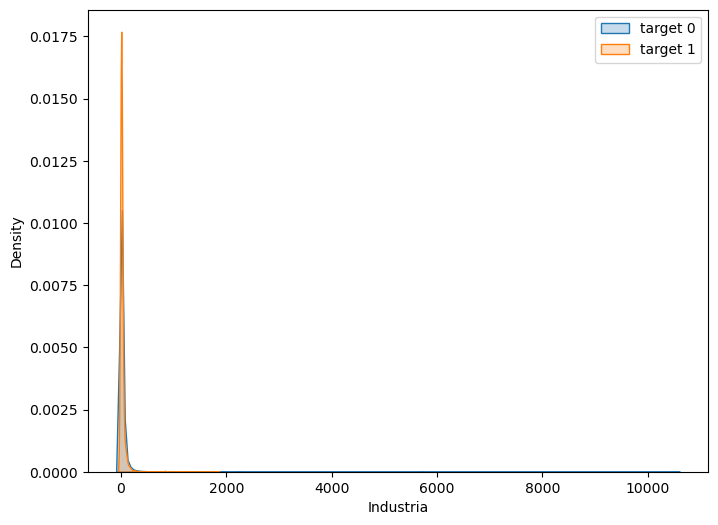

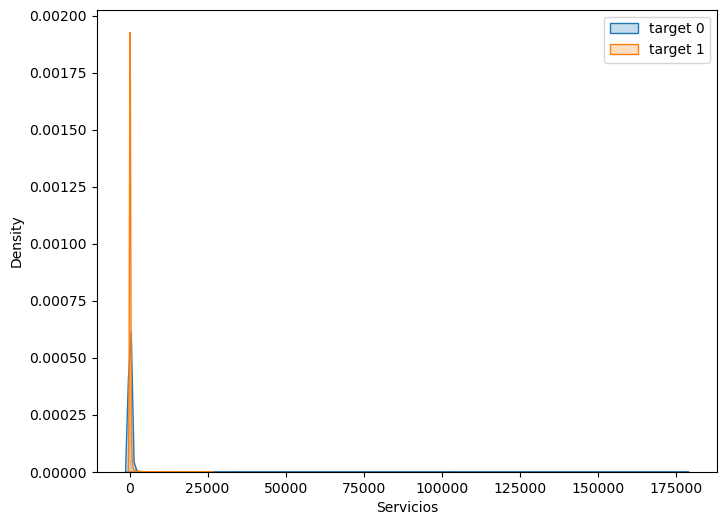

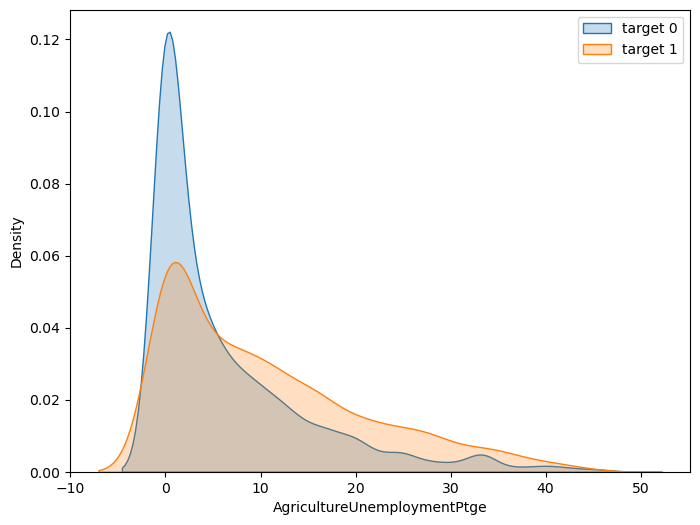

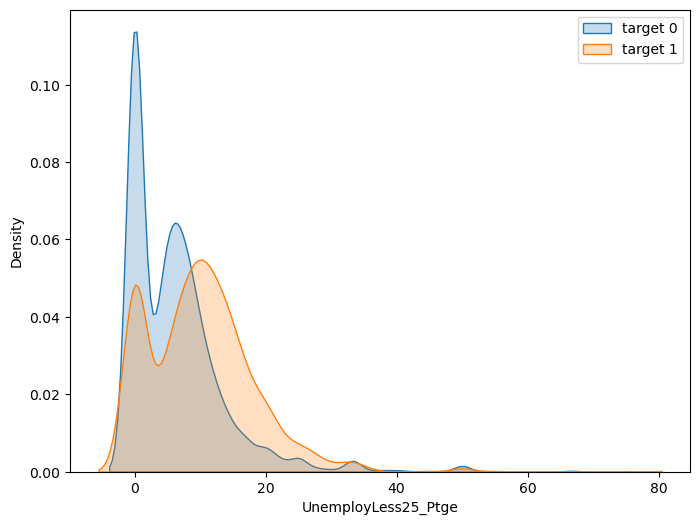

In [21]:
hist_targetbinaria(datos_input['Industria'],varObjIzquierda,'Industria')
hist_targetbinaria(datos_input['Servicios'],varObjIzquierda, 'Servicios')
hist_targetbinaria(datos_input['AgricultureUnemploymentPtge'],varObjIzquierda, 'AgricultureUnemploymentPtge')
hist_targetbinaria(datos_input['UnemployLess25_Ptge'],varObjIzquierda, 'UnemployLess25_Ptge')

<h4>Izda_Pct</h4>

In [22]:
resultados_Izda_Pct = []
for v in nombres_variables:
    coeficiente_cramer = Vcramer(datos_input[v], varObjIzdaPct)
    resultados_Izda_Pct.append((v,coeficiente_cramer))

resultados_Izda_Pct.sort(key=lambda x: x[1], reverse=True)

# Imprimir las variables ordenadas por valor p
print("Izquierda_Pct")
print("\nVariables predictoras significativas (ordenadas de mayor a menor asociacion ):\n")
for variable, coeficiente in resultados_Izda_Pct:
    print(f"{variable}: Coeficiente V de Cramer = {coeficiente}")

Izquierda_Pct

Variables predictoras significativas (ordenadas de mayor a menor asociacion ):

UnemployLess25_Ptge: Coeficiente V de Cramer = 0.2038833982385296
AgricultureUnemploymentPtge: Coeficiente V de Cramer = 0.14451728840335157
AbstentionPtge: Coeficiente V de Cramer = 0.14078541697030386
SameComAutonDiffProvPtge: Coeficiente V de Cramer = 0.12635508439133236
UnemployMore40_Ptge: Coeficiente V de Cramer = 0.12380657156559965
ActividadPpal: Coeficiente V de Cramer = 0.12001904706334858
SUPERFICIE: Coeficiente V de Cramer = 0.11803052494295344
IndustryUnemploymentPtge: Coeficiente V de Cramer = 0.11368794970915934
Age_0-4_Ptge: Coeficiente V de Cramer = 0.11072998895892325
Age_under19_Ptge: Coeficiente V de Cramer = 0.1100519036220996
Age_over65_pct: Coeficiente V de Cramer = 0.10855434008861196
Explotaciones: Coeficiente V de Cramer = 0.10729939713651747
inmuebles: Coeficiente V de Cramer = 0.10420062880271735
PersonasInmueble: Coeficiente V de Cramer = 0.10134820684356964
Popul

<ul>
    <li>Menos significativas: Age_0-4_Ptge  y PersonasInmueble</li>
    <li>Variable mas significativas: UnemployLess25_Ptge y SUPERFICIE</li>
</ul>

<h3>Relaciones entre variables predictoras continuas </h3>

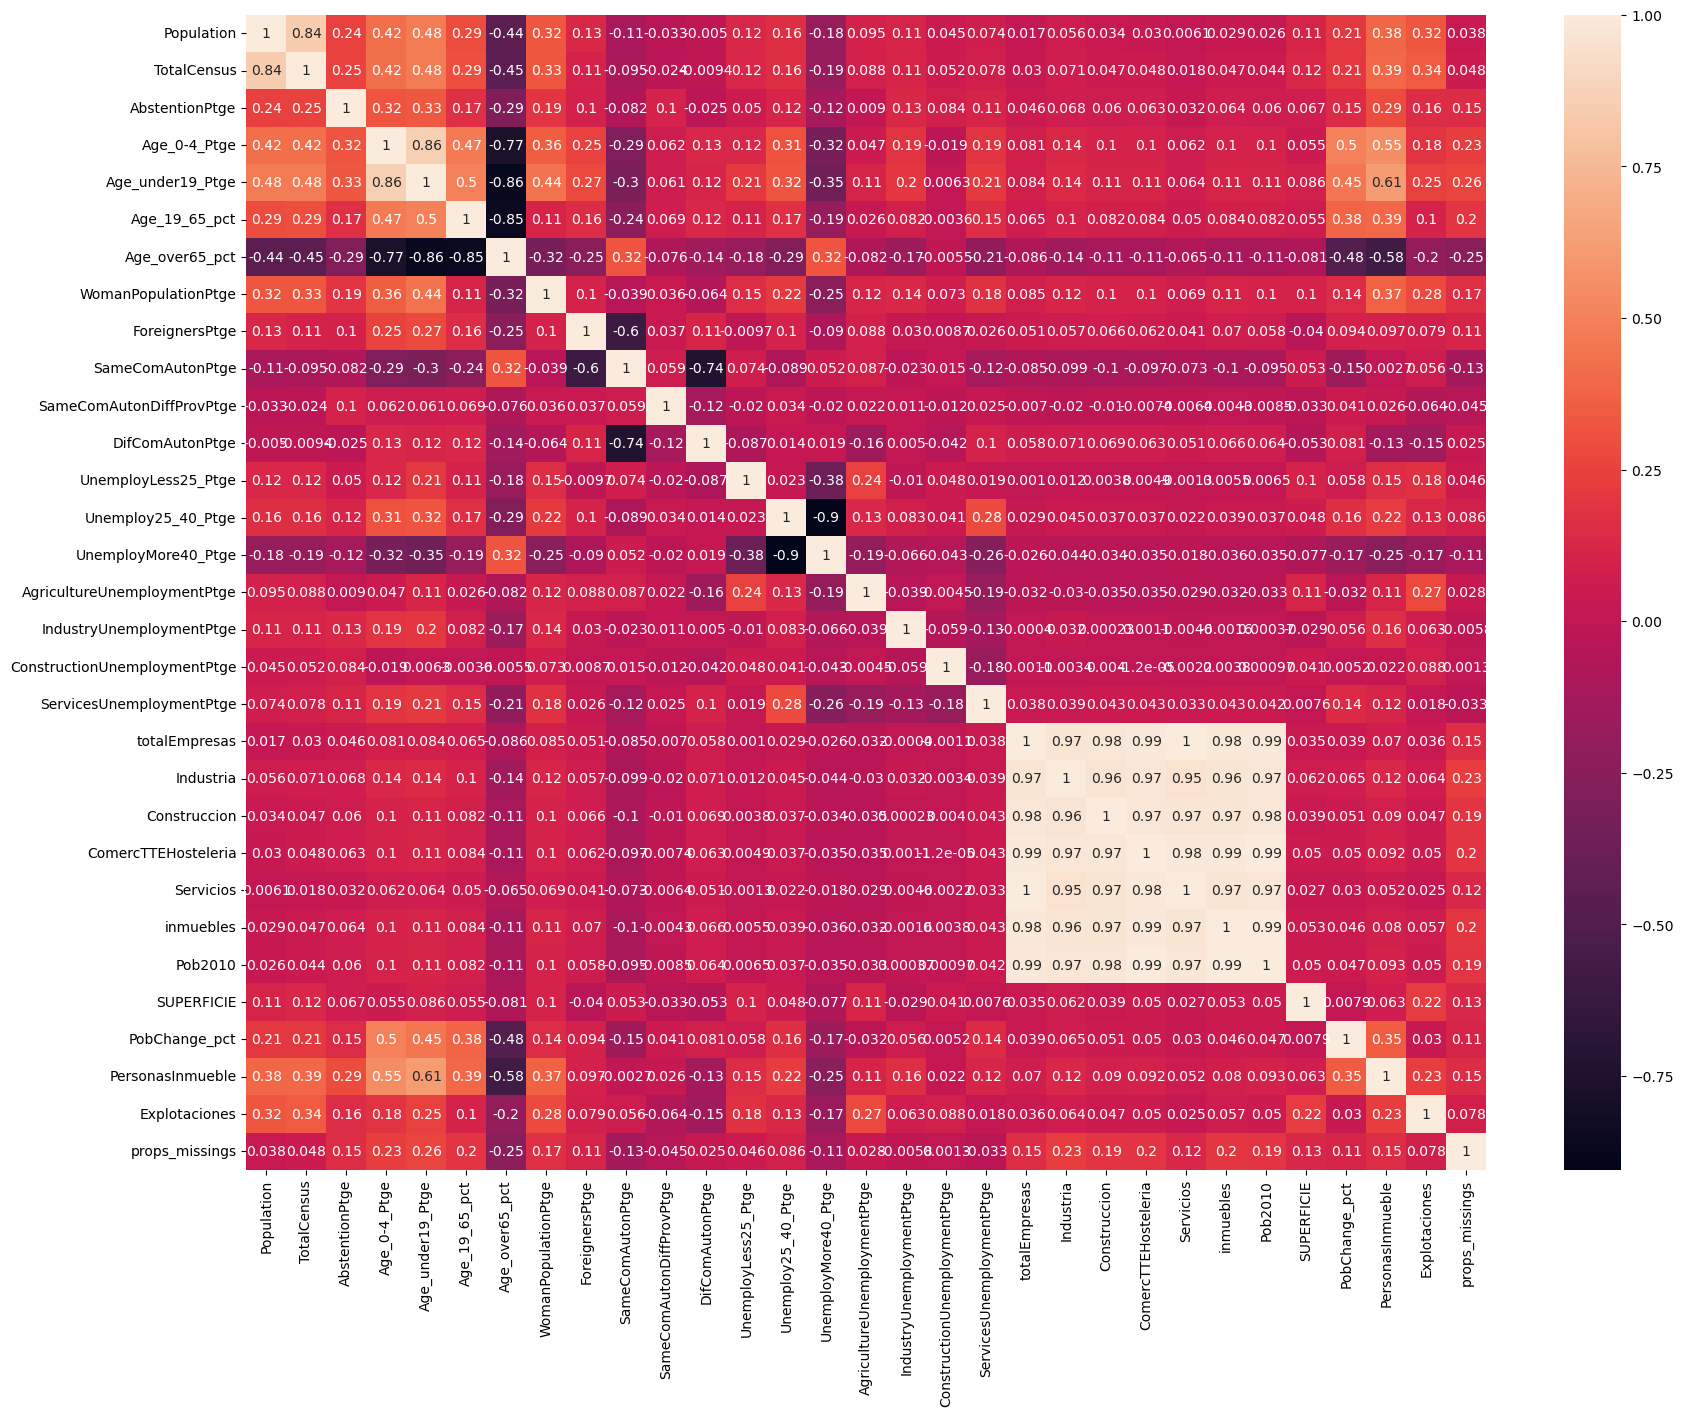

In [23]:
datos_input_continuas = datos_input.drop(['Densidad', 'ActividadPpal'], axis=1)

correlation_matrix = datos_input_continuas.corr()

# Visualizar la matriz de correlación con un mapa de calor
plt.figure(figsize=(20, 15)) 
sns.heatmap(correlation_matrix, annot=True)
plt.show()

Como se puede observar existe una fuertisima correlacion en el siguiente grupo de variables: totalEmpresas, Industria, Construccion, ComercTTEHoteleria, Servicios, inmuebles y pob2010. Al estar tan correladas la informacion que aporten para explicar la variable objetivo probablemente sea redundante entre ellas.

Analizando un poco la relacion que existe entre estas variables y las dos variables objetivos nos damos cuenta que no tienen especial relacion, de hecho (en su mayoria) estan entre las que menos relacion tienen. Debido a esto decidi que voy a remover del conjunto de datos todas menos una de las variables, dejando solo la que mejor desempeño tiene en cuanto a la relacion que presenta con las variables objetivo: "inmuebles"

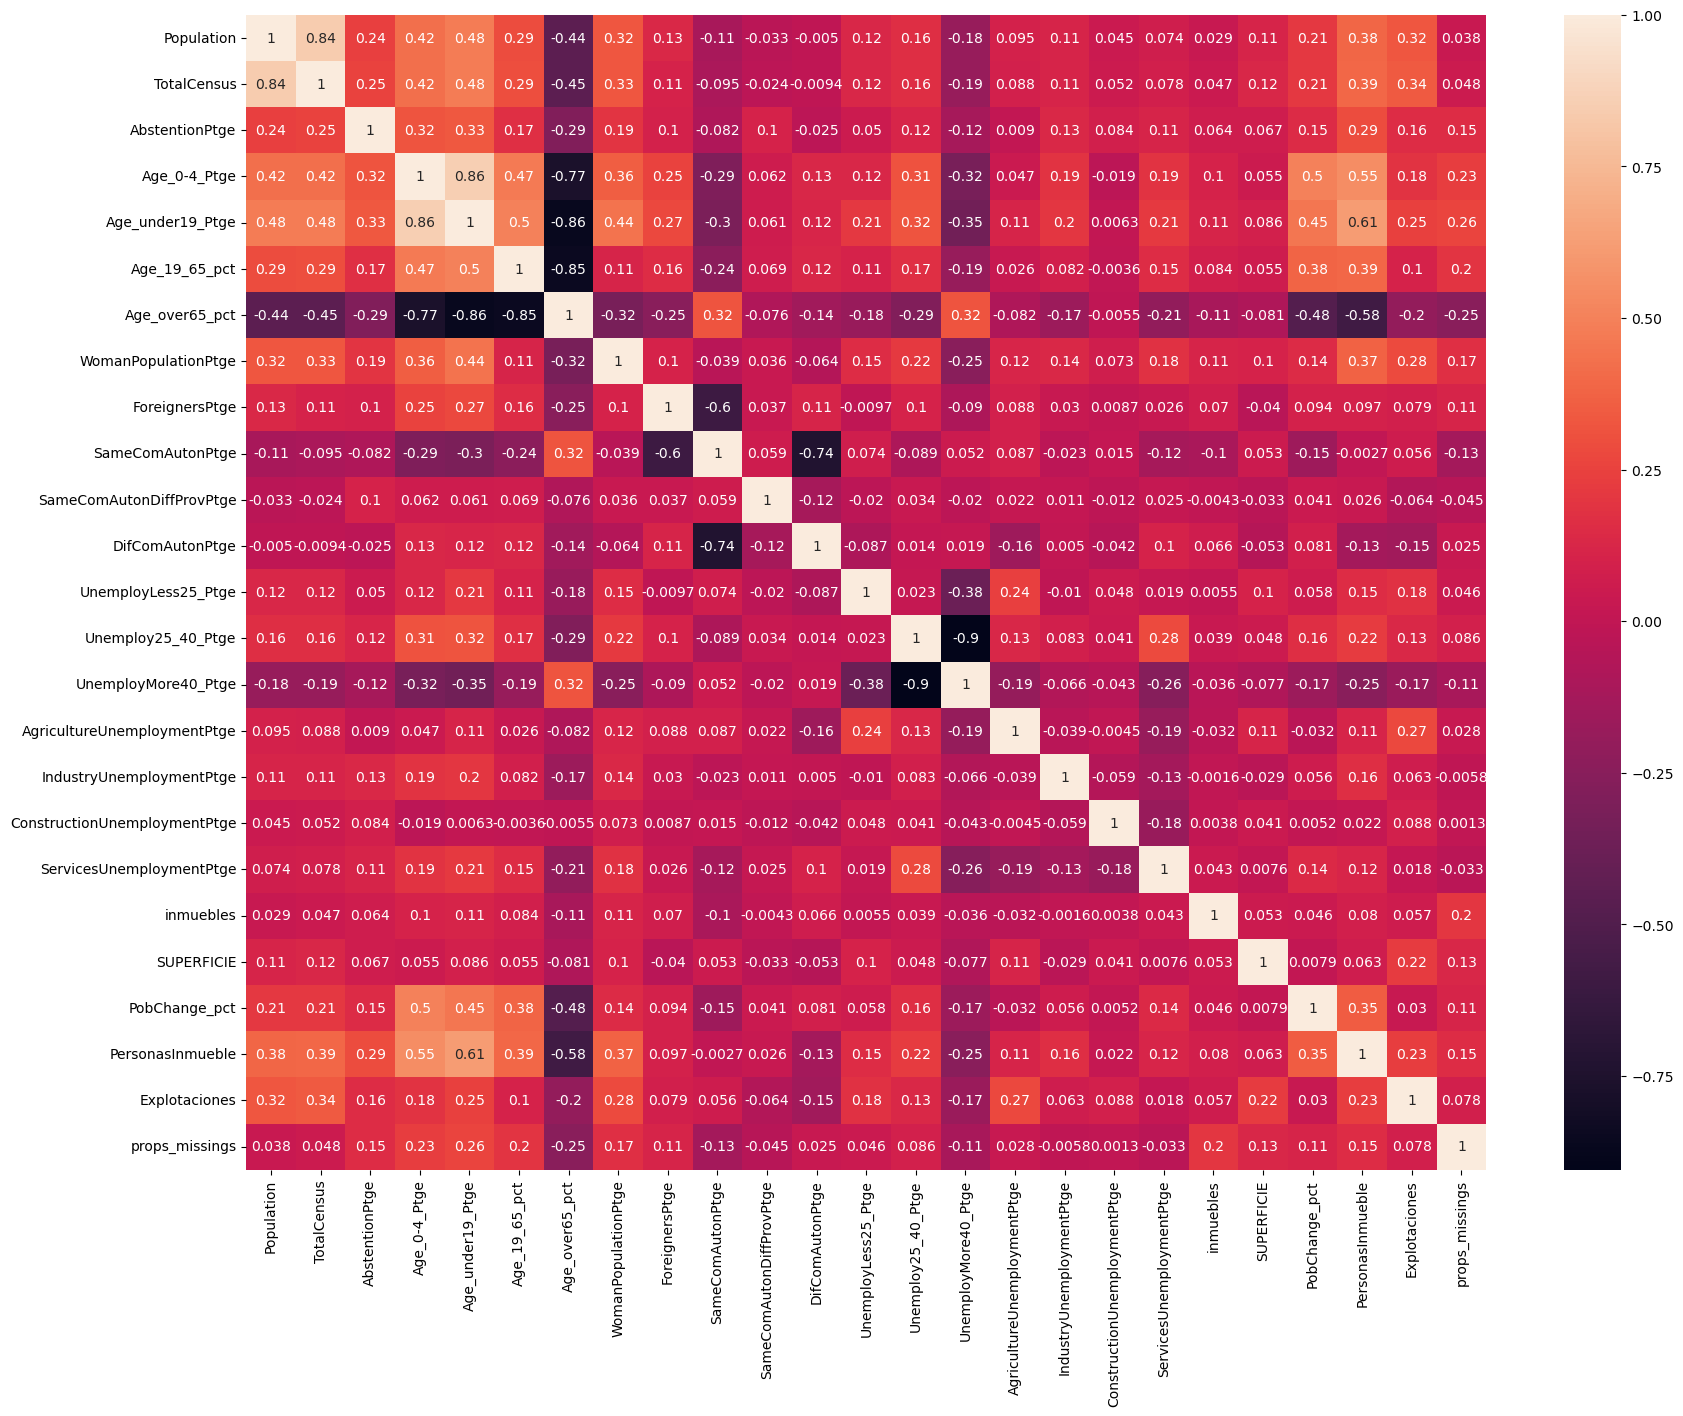

In [24]:
datos_input = datos_input.drop(['ComercTTEHosteleria', 'Industria', 'Servicios', 'Construccion', 'totalEmpresas', 'Pob2010'], axis=1)

datos_input_continuas = datos_input.drop(['Densidad', 'ActividadPpal'], axis=1)

correlation_matrix = datos_input_continuas.corr()

# Visualizar la matriz de correlación con un mapa de calor
plt.figure(figsize=(20, 15)) 
sns.heatmap(correlation_matrix, annot=True)
plt.show()

<h2> 8 - Elaboracion del modelo de Regresion Lineal - Variable Objetivo Izq_Pct</h2>

<h3>Muestras de entrenamiento y Test<h3>

Realizamos las particiones del conjunto de datos para entrenamiento del modelo y test, vamos a tener en cuenta todas las variables que han pasado por nuestra depuracion. Las particiones de datos para entrenamiento y prueba

In [25]:
izq_pct_predictoras_train, izq_pct_predictoras_test, izq_pct_objetivo_train, izq_pct_objetivo_test=train_test_split(
    datos_input, varObjIzdaPct, test_size=0.2, random_state=123456)


variables_predictoras_continuas = ['Population', 'TotalCensus', 'AbstentionPtge', 'Age_0-4_Ptge',
       'Age_under19_Ptge', 'Age_19_65_pct', 'Age_over65_pct',
       'WomanPopulationPtge', 'ForeignersPtge', 'SameComAutonPtge',
       'SameComAutonDiffProvPtge', 'DifComAutonPtge', 'UnemployLess25_Ptge',
       'Unemploy25_40_Ptge', 'UnemployMore40_Ptge',
       'AgricultureUnemploymentPtge', 'IndustryUnemploymentPtge',
       'ConstructionUnemploymentPtge', 'ServicesUnemploymentPtge',
       'inmuebles', 'SUPERFICIE', 'PobChange_pct',
       'PersonasInmueble', 'Explotaciones']

variables_predictoras_categoricas = ['Densidad', 'ActividadPpal']


<h3>Modelos a partir de metodos clasicos de seleccion de variables</h3>

<h5>Metodo Backward</h5>

In [26]:
rl_izq_pct_backward_aic =  lm_backward(izq_pct_objetivo_train, izq_pct_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas, metodo="AIC")

data_rl_izq_pct_backward_aic = crear_data_modelo(izq_pct_predictoras_test, rl_izq_pct_backward_aic['Variables']['cont'], 
                                                rl_izq_pct_backward_aic['Variables']['categ'], 
                                                rl_izq_pct_backward_aic['Variables']['inter'])

Start: AIC = 52991.67525162657

y ~ Population + TotalCensus + AbstentionPtge + Age_0-4_Ptge + Age_under19_Ptge + Age_19_65_pct + Age_over65_pct + WomanPopulationPtge + ForeignersPtge + SameComAutonPtge + SameComAutonDiffProvPtge + DifComAutonPtge + UnemployLess25_Ptge + Unemploy25_40_Ptge + UnemployMore40_Ptge + AgricultureUnemploymentPtge + IndustryUnemploymentPtge + ConstructionUnemploymentPtge + ServicesUnemploymentPtge + inmuebles + SUPERFICIE + PobChange_pct + PersonasInmueble + Explotaciones + Densidad + ActividadPpal

                       Variable          AIC
     - SameComAutonDiffProvPtge 53242.491394
  - AgricultureUnemploymentPtge 53115.594879
                - ActividadPpal 53093.669527
                   - SUPERFICIE 53079.052176
               - AbstentionPtge 53073.718495
     - IndustryUnemploymentPtge 53073.178547
          - UnemployLess25_Ptge 53070.962416
              - DifComAutonPtge 53056.631040
 - ConstructionUnemploymentPtge 53025.475185
                 -

In [27]:
rl_izq_pct_backward_bic =  lm_backward(izq_pct_objetivo_train, izq_pct_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas, metodo="BIC")

data_rl_izq_pct_backward_bic = crear_data_modelo(izq_pct_predictoras_test, rl_izq_pct_backward_bic['Variables']['cont'], 
                                                rl_izq_pct_backward_bic['Variables']['categ'], 
                                                rl_izq_pct_backward_bic['Variables']['inter'])

Start: BIC = 53201.808130154335

y ~ Population + TotalCensus + AbstentionPtge + Age_0-4_Ptge + Age_under19_Ptge + Age_19_65_pct + Age_over65_pct + WomanPopulationPtge + ForeignersPtge + SameComAutonPtge + SameComAutonDiffProvPtge + DifComAutonPtge + UnemployLess25_Ptge + Unemploy25_40_Ptge + UnemployMore40_Ptge + AgricultureUnemploymentPtge + IndustryUnemploymentPtge + ConstructionUnemploymentPtge + ServicesUnemploymentPtge + inmuebles + SUPERFICIE + PobChange_pct + PersonasInmueble + Explotaciones + Densidad + ActividadPpal

                       Variable          BIC
     - SameComAutonDiffProvPtge 53445.845792
  - AgricultureUnemploymentPtge 53318.949278
                   - SUPERFICIE 53282.406575
               - AbstentionPtge 53277.072893
                - ActividadPpal 53276.688486
     - IndustryUnemploymentPtge 53276.532946
          - UnemployLess25_Ptge 53274.316814
              - DifComAutonPtge 53259.985438
 - ConstructionUnemploymentPtge 53228.829583
                 

<h5>Metodo Forward</h5>

In [28]:
rl_izq_pct_forward_aic =  lm_forward(izq_pct_objetivo_train, izq_pct_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas, metodo="AIC")

data_rl_izq_pct_forward_aic = crear_data_modelo(izq_pct_predictoras_test, rl_izq_pct_forward_aic['Variables']['cont'], 
                                                rl_izq_pct_forward_aic['Variables']['categ'], 
                                                rl_izq_pct_forward_aic['Variables']['inter'])

Start: AIC = 54871.51659400477

y ~ 1

                       Variable          AIC
          + UnemployLess25_Ptge 54472.041735
     + SameComAutonDiffProvPtge 54519.928848
  + AgricultureUnemploymentPtge 54574.306754
                + ActividadPpal 54596.234522
                   + SUPERFICIE 54632.711460
                + Explotaciones 54674.260240
          + UnemployMore40_Ptge 54724.380715
     + IndustryUnemploymentPtge 54768.309222
              + DifComAutonPtge 54781.751750
               + AbstentionPtge 54787.395870
 + ConstructionUnemploymentPtge 54820.441802
               + ForeignersPtge 54822.270405
                  + TotalCensus 54825.725953
                   + Population 54830.537065
                + Age_19_65_pct 54832.801935
           + Unemploy25_40_Ptge 54838.663066
                     + Densidad 54839.289170
          + WomanPopulationPtge 54850.086457
               + Age_over65_pct 54851.004687
                 + Age_0-4_Ptge 54865.636546
             + S

In [29]:
rl_izq_pct_forward_bic =  lm_forward(izq_pct_objetivo_train, izq_pct_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas, metodo="BIC")

data_rl_izq_pct_forward_bic = crear_data_modelo(izq_pct_predictoras_test, rl_izq_pct_forward_bic['Variables']['cont'], 
                                                rl_izq_pct_forward_bic['Variables']['categ'], 
                                                rl_izq_pct_forward_bic['Variables']['inter'])

Start: BIC = 54878.29507395728

y ~ 1

                       Variable          BIC
          + UnemployLess25_Ptge 54485.598694
     + SameComAutonDiffProvPtge 54533.485808
  + AgricultureUnemploymentPtge 54587.863714
                + ActividadPpal 54630.126922
                   + SUPERFICIE 54646.268419
                + Explotaciones 54687.817199
          + UnemployMore40_Ptge 54737.937675
     + IndustryUnemploymentPtge 54781.866181
              + DifComAutonPtge 54795.308710
               + AbstentionPtge 54800.952830
 + ConstructionUnemploymentPtge 54833.998762
               + ForeignersPtge 54835.827365
                  + TotalCensus 54839.282912
                   + Population 54844.094024
                + Age_19_65_pct 54846.358895
           + Unemploy25_40_Ptge 54852.220026
                     + Densidad 54859.624610
          + WomanPopulationPtge 54863.643417
               + Age_over65_pct 54864.561647
                 + Age_0-4_Ptge 54879.193506
             + S

<h5>Método Stepwise</h5>

In [30]:
rl_izq_pct_stepwise_aic =  lm_stepwise(izq_pct_objetivo_train, izq_pct_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas,[],'AIC')

data_rl_izq_pct_stepwise_aic = crear_data_modelo(izq_pct_predictoras_test, rl_izq_pct_stepwise_aic['Variables']['cont'], 
                                                rl_izq_pct_stepwise_aic['Variables']['categ'], 
                                                rl_izq_pct_stepwise_aic['Variables']['inter'])

Start: AIC = 54871.51659400477

y ~ 1

                       Variable          AIC
          + UnemployLess25_Ptge 54472.041735
     + SameComAutonDiffProvPtge 54519.928848
  + AgricultureUnemploymentPtge 54574.306754
                + ActividadPpal 54596.234522
                   + SUPERFICIE 54632.711460
                + Explotaciones 54674.260240
          + UnemployMore40_Ptge 54724.380715
     + IndustryUnemploymentPtge 54768.309222
              + DifComAutonPtge 54781.751750
               + AbstentionPtge 54787.395870
 + ConstructionUnemploymentPtge 54820.441802
               + ForeignersPtge 54822.270405
                  + TotalCensus 54825.725953
                   + Population 54830.537065
                + Age_19_65_pct 54832.801935
           + Unemploy25_40_Ptge 54838.663066
                     + Densidad 54839.289170
          + WomanPopulationPtge 54850.086457
               + Age_over65_pct 54851.004687
                 + Age_0-4_Ptge 54865.636546
             + S

In [31]:
rl_izq_pct_stepwise_bic =  lm_stepwise(izq_pct_objetivo_train, izq_pct_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas,[],'BIC')

data_rl_izq_pct_stepwise_bic = crear_data_modelo(izq_pct_predictoras_test, rl_izq_pct_stepwise_bic['Variables']['cont'], 
                                                rl_izq_pct_stepwise_bic['Variables']['categ'], 
                                                rl_izq_pct_stepwise_bic['Variables']['inter'])

Start: BIC = 54878.29507395728

y ~ 1

                       Variable          BIC
          + UnemployLess25_Ptge 54485.598694
     + SameComAutonDiffProvPtge 54533.485808
  + AgricultureUnemploymentPtge 54587.863714
                + ActividadPpal 54630.126922
                   + SUPERFICIE 54646.268419
                + Explotaciones 54687.817199
          + UnemployMore40_Ptge 54737.937675
     + IndustryUnemploymentPtge 54781.866181
              + DifComAutonPtge 54795.308710
               + AbstentionPtge 54800.952830
 + ConstructionUnemploymentPtge 54833.998762
               + ForeignersPtge 54835.827365
                  + TotalCensus 54839.282912
                   + Population 54844.094024
                + Age_19_65_pct 54846.358895
           + Unemploy25_40_Ptge 54852.220026
                     + Densidad 54859.624610
          + WomanPopulationPtge 54863.643417
               + Age_over65_pct 54864.561647
                 + Age_0-4_Ptge 54879.193506
             + S

<h5>Comparativa de los metodos clasicos de seleccion de variables</h5>

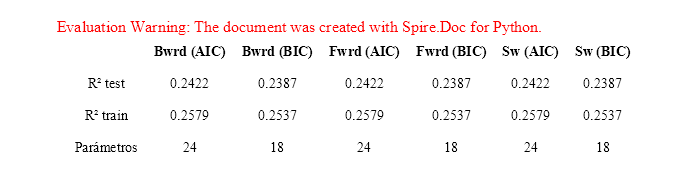

In [32]:
comparative_table_html_izq_pct = f"""
<!DOCTYPE html>
<html>
<head>
<style>
table {{
  table-layout: fixed;
  with: auto;
  border-collapse: collapse;
  margin: 10px;
}}

td, th {{
  height: auto;
  padding: 8px;
  font-size: 14px;
  text-align: center;
}}
</style>
</head>
<body>
<table>
  <thead>
    <tr>
      <th></th>
      <th>Bwrd (AIC)</th>
      <th>Bwrd (BIC)</th>
      <th>Fwrd (AIC)</th>
      <th>Fwrd (BIC)</th>
      <th>Sw (AIC)</th>
      <th>Sw (BIC)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>R² test</td>
      <td>{Rsq(rl_izq_pct_backward_aic['Modelo'],izq_pct_objetivo_test,data_rl_izq_pct_backward_aic):.4f}</td>
      <td>{Rsq(rl_izq_pct_backward_bic['Modelo'],izq_pct_objetivo_test,data_rl_izq_pct_backward_bic):.4f}</td>
      <td>{Rsq(rl_izq_pct_forward_aic['Modelo'],izq_pct_objetivo_test,data_rl_izq_pct_forward_aic):.4f}</td>
      <td>{Rsq(rl_izq_pct_forward_bic['Modelo'],izq_pct_objetivo_test,data_rl_izq_pct_forward_bic):.4f}</td>
      <td>{Rsq(rl_izq_pct_stepwise_aic['Modelo'],izq_pct_objetivo_test,data_rl_izq_pct_stepwise_aic):.4f}</td>
      <td>{Rsq(rl_izq_pct_stepwise_bic['Modelo'],izq_pct_objetivo_test,data_rl_izq_pct_stepwise_bic):.4f}</td>
    </tr>
    <tr>
      <td>R² train</td>
      <td>{Rsq(rl_izq_pct_backward_aic['Modelo'],izq_pct_objetivo_train,rl_izq_pct_backward_aic['X']):.4f}</td>
      <td>{Rsq(rl_izq_pct_backward_bic['Modelo'],izq_pct_objetivo_train,rl_izq_pct_backward_bic['X']):.4f}</td>
      <td>{Rsq(rl_izq_pct_forward_aic['Modelo'],izq_pct_objetivo_train,rl_izq_pct_forward_aic['X']):.4f}</td>
      <td>{Rsq(rl_izq_pct_forward_bic['Modelo'],izq_pct_objetivo_train,rl_izq_pct_forward_bic['X']):.4f}</td>
      <td>{Rsq(rl_izq_pct_stepwise_aic['Modelo'],izq_pct_objetivo_train,rl_izq_pct_stepwise_aic['X']):.4f}</td>
      <td>{Rsq(rl_izq_pct_stepwise_bic['Modelo'],izq_pct_objetivo_train,rl_izq_pct_stepwise_bic['X']):.4f}</td>
    </tr>
    <tr>
      <td>Parámetros</td>
      <td>{len(rl_izq_pct_backward_aic['Modelo'].params)}</td>
      <td>{len(rl_izq_pct_backward_bic['Modelo'].params)}</td>
      <td>{len(rl_izq_pct_forward_aic['Modelo'].params)}</td>
      <td>{len(rl_izq_pct_forward_bic['Modelo'].params)}</td>
      <td>{len(rl_izq_pct_stepwise_aic['Modelo'].params)}</td>
      <td>{len(rl_izq_pct_stepwise_bic['Modelo'].params)}</td>
    </tr>
  </tbody>
</table>
"""

document = Document()
sec = document.AddSection()
paragraph = sec.AddParagraph()
paragraph.AppendHTML(comparative_table_html_izq_pct)

imageStream = document.SaveImageToStreams(0, ImageType.Bitmap)

with open("./comparative_table_img_izq_pct.png",'wb') as imageFile:
    imageFile.write(imageStream.ToArray())
document.Close()

try:
  img = PILImage.open("./comparative_table_img_izq_pct.png")
  bbox = (10,10,700,200) 
  cropped_img = img.crop(bbox)
  cropped_img.save("./comparative_table_img_izq_pct.png") 
  display(Image(filename='./comparative_table_img_izq_pct.png'))
except:
  display(Image(filename='./comparative_table_img_izq_pct.png'))


<h3>Comparacion con metodo aleatorio de seleccion de variables y seleccion del modelo ganador</h3>

Los metodos backward, forward y stepwise son identicos en sus respectivas variantes AIC y BIC y la variabilidad del R² que presentan entre el conjunto de test y train es reducida. Lo que los diferencia es un R² algo superior en las variantes de BIC asi como unos cuantos parametros mas. 

La seleccion no es sencilla porque la diferencia del R² no es tan reducida como para considerarla despreciable asi como el numero de paraemtros es tambien una diferencia considerable, me voy a decantar por tener un menor numero de parametros porque el R² no es muy bajo en ambos modelos, el modelo explica muy mal la variable objetivo para ambos modelos por lo que aunque la diferencia no sea del todo despreciable el R² es tan bajo que no creo que tenga demsiado peso el argumento de la diferencia que hay en la capacidad explicativa de los modelos. Con estas consideraciones elejimos el modelo que utilizo el metodo de seleccion de variables Stepwise con el criterio BIC

In [33]:
variables_seleccionadas = {
    'Formula': [],
    'Variables': []
}

for x in range(30):
    print('---------------------------- iter: ' + str(x))
    
    x_train2, x_test2, y_train2, y_test2 = train_test_split(izq_pct_predictoras_train, izquierda_objetivo_train, 
                                                            test_size = 0.3, random_state = 1234567 + x)
    
    modelo = lm_stepwise(y_train2.astype(int), x_train2, variables_predictoras_continuas, variables_predictoras_categoricas, [], 'BIC')
    
    variables_seleccionadas['Variables'].append(modelo['Variables'])
    variables_seleccionadas['Formula'].append(sorted(modelo['Modelo'].model.exog_names))

variables_seleccionadas['Formula'] = list(map(lambda x: '+'.join(x), variables_seleccionadas['Formula']))

frecuencias = Counter(variables_seleccionadas['Formula'])
frec_ordenada = pd.DataFrame(list(frecuencias.items()), columns = ['Formula', 'Frecuencia'])
frec_ordenada = frec_ordenada.sort_values('Frecuencia', ascending = False).reset_index()

var_1 = variables_seleccionadas['Variables'][variables_seleccionadas['Formula'].index(
    frec_ordenada['Formula'][0])]
var_2 = variables_seleccionadas['Variables'][variables_seleccionadas['Formula'].index(
    frec_ordenada['Formula'][1])]


---------------------------- iter: 0


NameError: name 'izquierda_objetivo_train' is not defined

Comparamos el modelo ganador de la seleccion por los metodos clasicos con los dos nuevos modelos.

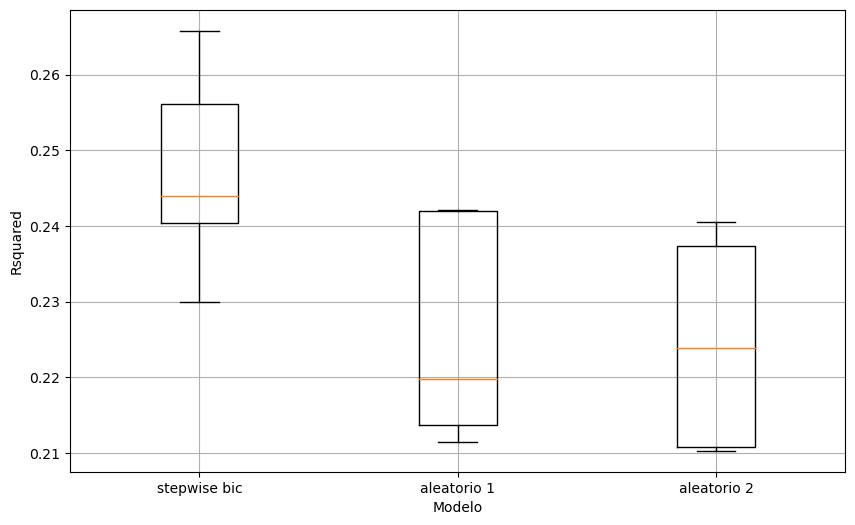

In [ ]:
results = pd.DataFrame({
    'Rsquared': []
    , 'Resample': []
    , 'Modelo': []
})
for rep in range(20):
    modelo1 = validacion_cruzada_lm(
        5
        , izq_pct_predictoras_train
        , izq_pct_objetivo_train
        , rl_izq_pct_stepwise_bic['Variables']['cont']
        , rl_izq_pct_stepwise_bic['Variables']['categ']
        , rl_izq_pct_stepwise_bic['Variables']['inter']
    )
    modelo2 = validacion_cruzada_lm(
        5
        , izq_pct_predictoras_train
        , izq_pct_objetivo_train
        , var_1['cont']
        , var_1['categ']
        , var_1['inter']
    )
    modelo3 = validacion_cruzada_lm(
        5
        , izq_pct_predictoras_train
        , izq_pct_objetivo_train
        , var_2['cont']
        , var_2['categ']
        , var_2['inter']
    )
    
    results_rep = pd.DataFrame({
        'Rsquared': modelo1 + modelo2 + modelo3 
        , 'Resample': ['Rep' + str((rep + 1))]*5*3
        , 'Modelo': [1]*5 + [2]*5 + [3]*5 
    })
    results = pd.concat([results, results_rep], axis = 0)


plt.figure(figsize=(10, 6)) 
plt.grid(True)  

grupo_metrica = results.groupby('Modelo')['Rsquared']
boxplot_data = [grupo_metrica.get_group(grupo).tolist() for grupo in grupo_metrica.groups]

model_labels = ["stepwise bic", "aleatorio 1", "aleatorio 2"]
plt.boxplot(boxplot_data, labels=model_labels)

plt.xlabel('Modelo')  
plt.ylabel('Rsquared')  
plt.show() 


In [ ]:
print("Numero de parametros para stepwise bic: "+ str(len(rl_izq_pct_stepwise_bic['Modelo'].params)))
print("Numero de parametros para modelo con seleccionde varaibles aleatorias 1: " + str(len(var_1['cont'])+len(var_1['categ'])))
print("Numero de parametros para con selccion de variables aleatorio 2: "+ str(len(var_2['cont'])+len(var_2['categ'])))

Numero de parametros para stepwise bic: 18
Numero de parametros para modelo con seleccionde varaibles aleatorias 1: 10
Numero de parametros para con selccion de variables aleatorio 2: 10


Como podemos visualizar en el diagrama de cajas realizado para los modelos aletorios tienen un R² muy similar, los modelos relizados con los metodo de seleccion aleatoria de varaibles
 presenta un r apenas inferior (0.220 y 0.224 vs 0.243 del obtenido por el metodo de seleccion clasica de variables)

 En lo que difieren bastante es en el numero de parametros, donde las variables son considerablemente menos en los modelos obtenidos por el metodo aleatoria de seleccion de variables.

Sin embargo elegimos como modelo ganador al primero obtenido con el metodo clasico de seleccion de variables debido a que tiene el R² mas alto y el numero de parametros no es tan considerable.

<h3>Interpretacion de los modelos ganadores y medicion de calidad<h3>

In [ ]:
rl_izq_pct_stepwise_bic["Modelo"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Izda_Pct   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     129.5
Date:                Wed, 19 Feb 2025   Prob (F-statistic):               0.00
Time:                        14:15:55   Log-Likelihood:                -26484.
No. Observations:                6493   AIC:                         5.300e+04
Df Residuals:                    6475   BIC:                         5.313e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           23.9528      1.995     12.005      0.000      20.042      27.864
UnemployLess25_Ptge              0.3730      0.024     15.614      0.000       0.326       0.420
SameComAutonDiffProvPtge        -0.6238      0.040    -15.485      0.000      -0.703      -0.545
AgricultureUnemploymentPtge      0.2577      0.021     12.416      0.000       0.217       0.298
SUPERFICIE                       0.0002   1.99e-05     11.085      0.000       0.000       0.000
DifComAutonPtge                  0.3683      0.023     15.725      0.000       0.322       0.414
IndustryUnemploymentPtge        -0.1645      0.018     -9.305      0.000      -0.199      -0.130
AbstentionPtge                  -0.2377      0.025     -9.326      0.000      -0.288      -0.188
ForeignersPtge                  -0.2235      0.026     -8.538      0.000      -0.275      -0.172
ConstructionUnemploymentPtge     0.1064      0.016      6.603      0.000       0.075       0.138
Age_19_65_pct                    0.2302      0.031      7.382      0.000       0.169       0.291
Age_0-4_Ptge                    -0.7449      0.119     -6.262      0.000      -0.978      -0.512
Unemploy25_40_Ptge               0.0574      0.009      6.161      0.000       0.039       0.076
Explotaciones                    0.0116      0.002      5.034      0.000       0.007       0.016
ActividadPpal_Construccion      -6.0953      4.334     -1.406      0.160     -14.591       2.401
ActividadPpal_Industria          0.9926      4.332      0.229      0.819      -7.500       9.485
ActividadPpal_Otros             -3.5880      0.529     -6.777      0.000      -4.626      -2.550
ActividadPpal_Servicios         -8.1094      0.756    -10.732      0.000      -9.591      -6.628
==============================================================================
Omnibus:                       50.361   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.660
Skew:                           0.206   Prob(JB):                     9.99e-12
Kurtosis:                       2.866   Cond. No.                     2.72e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.72e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Se puede observar que el parametro ActividadPpal_Industria no es significativo para el modelo, lo ideal seria removerlo pero eso llevaria a recrear todos los modelos devuelta y a volver a evaluarlos, por el limitado plazo que tenemos para este trabajo voy a ignorar este paso pero seria lo mas conveniente para analizar a ver si mejorar el modelo sin esta variable. Algo similar pasa con ActividadPpal_Construccion aunque en menor medida.

Ya que estamos mas familiarizados tomemos los mismos dos parametros que tomamos con la variable predictora izquierda para analizar el significado de sus coeficientes. Recordemos que la variable objetivo Izq_Pct toma valores entre 0 y 100 representando el porcentaje de voto a la izquierda:

<li>UnemployLess25_Ptge: el coeficiente es 0.3730 por lo que podemos decir el porcentaje de desempeados juveniles a contribuir a aumentar el porcentaje de votos de la izquierda. </li>
<br>
<li>ActividadPpal: los coeficientes de la actividad servicios, construccion y otros son negativas (-8.1094, -6.0953, -3.5880 respectivamente) esto significa que si cualquiera de esas actividades son actividades principales en el municipio van a reducir el porcentaje de los votos de la izquierda un 8%, un 6% y un 3.6% respectivamente. La industria en cambio va aumentar ligeramente los votos de la izquierda en un 1%</li>

Ahora vamos a medir la calidad del modelo

In [ ]:
print('R² de train: '+str(Rsq( rl_izq_pct_stepwise_bic['Modelo'], izq_pct_objetivo_train, rl_izq_pct_stepwise_bic['X'])))
print("R² de test: "+str(Rsq(rl_izq_pct_stepwise_bic['Modelo'], izq_pct_objetivo_test, data_rl_izq_pct_stepwise_bic)))
print("nro de parametros: "+ str(len(rl_izq_pct_backward_bic["Modelo"].params)))

R² de train: 0.2538026182030525
R² de test: 0.23791412002920964
nro de parametros: 18


Como podemos observar en la tabla resumen y en el R² de test y de train el modelo tiene una buena cohesion debido a una baja varaibilidad entre los R² de test y train asi como un numero de parametros aceptable.

El estadistico F nos indica que en el modelo hay evidencia estadistica solida para indicar que al menos una variable explica a la variable objetivo. Por otro lado podemos ver que casi todas las variables son significativas para el modelo pero hay dos que no lo son: ActividadPpal_Industria y ActividadPpal_Construccion en ambos casos el estadistico nos indica que es probable que no esten aportando informacion al modelo.

Es no menor indicar que el R² es muy bajo, demasiado bajo, por lo que es probable que explica poco a la variable objetivo y el error en las predicciones sea muy alto. Para mejorarlo se pueden hacer ciertas modificaciones como por ejemplo transformar las variables numericas, yo uso una herramienta en mi IDE que me permite ver las distribuciones de las variables y pude observar que hay varias con valores muy condensados por lo que una transoformacion logaritmica contribuiria a dispersar los valores, como ese ejemplo se pueden hacer muchas cosas que hagan que las variables explicativas aporten mas informacion aumetando la capacidad explicativa del modelo

<h2>9 - Regresion Logistica - Variable objetivo Izquierda</h2>

<h3><h3>Muestras de entrenamiento y Test<h3></h3>

In [36]:
izquierda_predictoras_train, izquierda_predictoras_test, izquierda_objetivo_train, izquierda_objetivo_test=train_test_split(
    datos_input, varObjIzquierda, test_size=0.2, random_state=123456)


variables_predictoras_continuas = ['Population', 'TotalCensus', 'AbstentionPtge', 'Age_0-4_Ptge',
       'Age_under19_Ptge', 'Age_19_65_pct', 'Age_over65_pct',
       'WomanPopulationPtge', 'ForeignersPtge', 'SameComAutonPtge',
       'SameComAutonDiffProvPtge', 'DifComAutonPtge', 'UnemployLess25_Ptge',
       'Unemploy25_40_Ptge', 'UnemployMore40_Ptge',
       'AgricultureUnemploymentPtge', 'IndustryUnemploymentPtge',
       'ConstructionUnemploymentPtge', 'ServicesUnemploymentPtge',
       'inmuebles', 'SUPERFICIE', 'PobChange_pct',
       'PersonasInmueble', 'Explotaciones']

variables_predictoras_categoricas = ['Densidad', 'ActividadPpal']

<h3> Seleccion de variables predictoras por metodos clasicos <h3>

<h4>Metodo Backward</h4>

In [37]:
glm_izquierda_backward_aic =  glm_backward(izquierda_objetivo_train, izquierda_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas, metodo="AIC")

data_glm_izquierda_backward_aic = crear_data_modelo(izquierda_predictoras_test, glm_izquierda_backward_aic['Variables']['cont'], 
                                                glm_izquierda_backward_aic['Variables']['categ'], 
                                                glm_izquierda_backward_aic['Variables']['inter'])

Start: AIC = 6073.359907701748

y ~ Population + TotalCensus + AbstentionPtge + Age_0-4_Ptge + Age_under19_Ptge + Age_19_65_pct + Age_over65_pct + WomanPopulationPtge + ForeignersPtge + SameComAutonPtge + SameComAutonDiffProvPtge + DifComAutonPtge + UnemployLess25_Ptge + Unemploy25_40_Ptge + UnemployMore40_Ptge + AgricultureUnemploymentPtge + IndustryUnemploymentPtge + ConstructionUnemploymentPtge + ServicesUnemploymentPtge + inmuebles + SUPERFICIE + PobChange_pct + PersonasInmueble + Explotaciones + Densidad + ActividadPpal

                       Variable         AIC
  - AgricultureUnemploymentPtge 6136.365414
     - SameComAutonDiffProvPtge 6133.170050
                - ActividadPpal 6120.539757
     - IndustryUnemploymentPtge 6106.802362
              - DifComAutonPtge 6101.366356
          - UnemployLess25_Ptge 6098.334063
                   - SUPERFICIE 6093.756979
                 - Age_0-4_Ptge 6086.078197
               - ForeignersPtge 6085.700688
                - Explotacio

In [38]:
glm_izquierda_backward_bic =  glm_backward(izquierda_objetivo_train, izquierda_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas, metodo="BIC")

data_glm_izquierda_backward_bic = crear_data_modelo(izquierda_predictoras_test, glm_izquierda_backward_bic['Variables']['cont'], 
                                                glm_izquierda_backward_bic['Variables']['categ'], 
                                                glm_izquierda_backward_bic['Variables']['inter'])

Start: BIC = 6086.916867606765

y ~ Population + TotalCensus + AbstentionPtge + Age_0-4_Ptge + Age_under19_Ptge + Age_19_65_pct + Age_over65_pct + WomanPopulationPtge + ForeignersPtge + SameComAutonPtge + SameComAutonDiffProvPtge + DifComAutonPtge + UnemployLess25_Ptge + Unemploy25_40_Ptge + UnemployMore40_Ptge + AgricultureUnemploymentPtge + IndustryUnemploymentPtge + ConstructionUnemploymentPtge + ServicesUnemploymentPtge + inmuebles + SUPERFICIE + PobChange_pct + PersonasInmueble + Explotaciones + Densidad + ActividadPpal

                       Variable         BIC
  - AgricultureUnemploymentPtge 6149.922374
     - SameComAutonDiffProvPtge 6146.727010
                - ActividadPpal 6134.096717
     - IndustryUnemploymentPtge 6120.359322
              - DifComAutonPtge 6114.923316
          - UnemployLess25_Ptge 6111.891023
                   - SUPERFICIE 6107.313939
                 - Age_0-4_Ptge 6099.635157
               - ForeignersPtge 6099.257648
                - Explotacio

<h4>Metodo Forward</h4>

In [39]:
glm_izquierda_forward_aic =  glm_forward(izquierda_objetivo_train, izquierda_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas, metodo="AIC")

data_glm_izquierda_forward_aic = crear_data_modelo(izquierda_predictoras_test, glm_izquierda_forward_aic['Variables']['cont'], 
                                                glm_izquierda_forward_aic['Variables']['categ'], 
                                                glm_izquierda_forward_aic['Variables']['inter'])

Start: AIC = 6922.902178798493

y ~ 1

                       Variable         AIC
          + UnemployLess25_Ptge 6696.331045
  + AgricultureUnemploymentPtge 6723.281190
                + ActividadPpal 6728.444332
                + Explotaciones 6790.730916
                   + SUPERFICIE 6808.632358
          + UnemployMore40_Ptge 6833.095295
               + Age_over65_pct 6850.882780
     + SameComAutonDiffProvPtge 6852.712491
                + Age_19_65_pct 6859.487620
                  + TotalCensus 6873.970968
             + Age_under19_Ptge 6874.993463
                   + Population 6876.941744
               + ForeignersPtge 6878.363074
          + WomanPopulationPtge 6882.567012
             + PersonasInmueble 6891.088277
     + IndustryUnemploymentPtge 6892.574302
 + ConstructionUnemploymentPtge 6903.436226
           + Unemploy25_40_Ptge 6904.775403
                     + Densidad 6914.252417
             + SameComAutonPtge 6915.096705
               + AbstentionPtge 6916.

In [40]:
glm_izquierda_forward_bic =  glm_forward(izquierda_objetivo_train, izquierda_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas, metodo="BIC")

data_glm_izquierda_forward_bic = crear_data_modelo(izquierda_predictoras_test, glm_izquierda_forward_bic['Variables']['cont'], 
                                                glm_izquierda_forward_bic['Variables']['categ'], 
                                                glm_izquierda_forward_bic['Variables']['inter'])

Start: BIC = 6936.45913870351

y ~ 1

                       Variable         BIC
          + UnemployLess25_Ptge 6709.888005
  + AgricultureUnemploymentPtge 6736.838150
                + ActividadPpal 6742.001292
                + Explotaciones 6804.287875
                   + SUPERFICIE 6822.189318
          + UnemployMore40_Ptge 6846.652255
               + Age_over65_pct 6864.439740
     + SameComAutonDiffProvPtge 6866.269451
                + Age_19_65_pct 6873.044580
                  + TotalCensus 6887.527928
             + Age_under19_Ptge 6888.550423
                   + Population 6890.498704
               + ForeignersPtge 6891.920034
          + WomanPopulationPtge 6896.123972
             + PersonasInmueble 6904.645236
     + IndustryUnemploymentPtge 6906.131262
 + ConstructionUnemploymentPtge 6916.993186
           + Unemploy25_40_Ptge 6918.332363
                     + Densidad 6927.809377
             + SameComAutonPtge 6928.653665
               + AbstentionPtge 6929.6

<h4>Metodo Stepwise</h4>

In [41]:
glm_izquierda_stepwise_aic =  glm_stepwise(izquierda_objetivo_train, izquierda_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas, metodo="AIC")

data_glm_izquierda_stepwise_aic = crear_data_modelo(izquierda_predictoras_test, glm_izquierda_stepwise_aic['Variables']['cont'], 
                                                glm_izquierda_stepwise_aic['Variables']['categ'], 
                                                glm_izquierda_stepwise_aic['Variables']['inter'])

Start: AIC = 6922.902178798493

y ~ 1

                       Variable         AIC
          + UnemployLess25_Ptge 6696.331045
  + AgricultureUnemploymentPtge 6723.281190
                + ActividadPpal 6728.444332
                + Explotaciones 6790.730916
                   + SUPERFICIE 6808.632358
          + UnemployMore40_Ptge 6833.095295
               + Age_over65_pct 6850.882780
     + SameComAutonDiffProvPtge 6852.712491
                + Age_19_65_pct 6859.487620
                  + TotalCensus 6873.970968
             + Age_under19_Ptge 6874.993463
                   + Population 6876.941744
               + ForeignersPtge 6878.363074
          + WomanPopulationPtge 6882.567012
             + PersonasInmueble 6891.088277
     + IndustryUnemploymentPtge 6892.574302
 + ConstructionUnemploymentPtge 6903.436226
           + Unemploy25_40_Ptge 6904.775403
                     + Densidad 6914.252417
             + SameComAutonPtge 6915.096705
               + AbstentionPtge 6916.

In [42]:
glm_izquierda_stepwise_bic =  glm_stepwise(izquierda_objetivo_train, izquierda_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas, metodo="BIC")

data_glm_izquierda_stepwise_bic = crear_data_modelo(izquierda_predictoras_test, glm_izquierda_stepwise_bic['Variables']['cont'], 
                                                glm_izquierda_stepwise_bic['Variables']['categ'], 
                                                glm_izquierda_stepwise_bic['Variables']['inter'])

Start: BIC = 6936.45913870351

y ~ 1

                       Variable         BIC
          + UnemployLess25_Ptge 6709.888005
  + AgricultureUnemploymentPtge 6736.838150
                + ActividadPpal 6742.001292
                + Explotaciones 6804.287875
                   + SUPERFICIE 6822.189318
          + UnemployMore40_Ptge 6846.652255
               + Age_over65_pct 6864.439740
     + SameComAutonDiffProvPtge 6866.269451
                + Age_19_65_pct 6873.044580
                  + TotalCensus 6887.527928
             + Age_under19_Ptge 6888.550423
                   + Population 6890.498704
               + ForeignersPtge 6891.920034
          + WomanPopulationPtge 6896.123972
             + PersonasInmueble 6904.645236
     + IndustryUnemploymentPtge 6906.131262
 + ConstructionUnemploymentPtge 6916.993186
           + Unemploy25_40_Ptge 6918.332363
                     + Densidad 6927.809377
             + SameComAutonPtge 6928.653665
               + AbstentionPtge 6929.6

<h5>Comparativa de los metodos clasicos de seleccion de variables</h5>

In [ ]:
comparative_table_html_izquierda = f"""
<!DOCTYPE html>
<html>
<head>
<style>
table {{
  table-layout: fixed;
  with: auto;
  border-collapse: collapse;
  margin: 10px;
}}

td, th {{
  height: auto;
  padding: 8px;
  font-size: 14px;
  text-align: center;
}}
</style>
</head>
<body>
<table>
  <thead>
    <tr>
      <th></th>
      <th>Bwrd (AIC)</th>
      <th>Bwrd (BIC)</th>
      <th>Fwrd (AIC)</th>
      <th>Fwrd (BIC)</th>
      <th>Sw (AIC)</th>
      <th>Sw (BIC)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Pseudo R² test</td>
      <td>{pseudoR2(glm_izquierda_backward_aic['Modelo'],data_glm_izquierda_backward_aic,izquierda_objetivo_test):.4f}</td>
      <td>{pseudoR2(glm_izquierda_backward_bic['Modelo'],data_glm_izquierda_backward_bic,izquierda_objetivo_test):.4f}</td>
      <td>{pseudoR2(glm_izquierda_forward_aic['Modelo'],data_glm_izquierda_forward_aic,izquierda_objetivo_test):.4f}</td>
      <td>{pseudoR2(glm_izquierda_forward_bic['Modelo'],data_glm_izquierda_forward_bic,izquierda_objetivo_test):.4f}</td>
      <td>{pseudoR2(glm_izquierda_stepwise_aic['Modelo'],data_glm_izquierda_stepwise_aic,izquierda_objetivo_test):.4f}</td>
      <td>{pseudoR2(glm_izquierda_stepwise_bic['Modelo'],data_glm_izquierda_stepwise_bic,izquierda_objetivo_test):.4f}</td>
    </tr>
    <tr>
      <td>Pseudo R² train</td>
      <td>{pseudoR2(glm_izquierda_backward_aic['Modelo'],glm_izquierda_backward_aic['X'],izquierda_objetivo_train):.4f}</td>
      <td>{pseudoR2(glm_izquierda_backward_bic['Modelo'],glm_izquierda_backward_bic['X'],izquierda_objetivo_train):.4f}</td>
      <td>{pseudoR2(glm_izquierda_forward_aic['Modelo'],glm_izquierda_forward_aic['X'],izquierda_objetivo_train):.4f}</td>
      <td>{pseudoR2(glm_izquierda_forward_bic['Modelo'],glm_izquierda_forward_bic['X'],izquierda_objetivo_train):.4f}</td>
      <td>{pseudoR2(glm_izquierda_stepwise_aic['Modelo'],glm_izquierda_stepwise_aic['X'],izquierda_objetivo_train):.4f}</td>
      <td>{pseudoR2(glm_izquierda_stepwise_bic['Modelo'],glm_izquierda_stepwise_bic['X'],izquierda_objetivo_train):.4f}</td>
    </tr>
    <tr>
      <td>Parámetros</td>
      <td>{len(glm_izquierda_backward_aic['Modelo'].coef_[0])}</td>
      <td>{len(glm_izquierda_backward_bic['Modelo'].coef_[0])}</td>
      <td>{len(glm_izquierda_forward_aic['Modelo'].coef_[0])}</td>
      <td>{len(glm_izquierda_forward_bic['Modelo'].coef_[0])}</td>
      <td>{len(glm_izquierda_stepwise_aic['Modelo'].coef_[0])}</td>
      <td>{len(glm_izquierda_stepwise_bic['Modelo'].coef_[0])}</td>
    </tr>
  </tbody>
</table>
"""

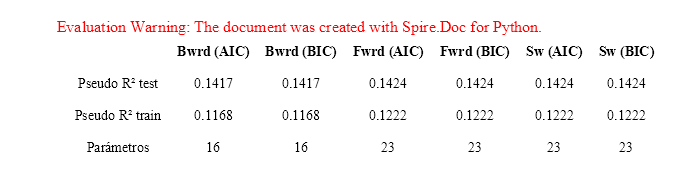

In [44]:
document = Document()
sec = document.AddSection()
paragraph = sec.AddParagraph()
paragraph.AppendHTML(comparative_table_html_izquierda)

imageStream = document.SaveImageToStreams(0, ImageType.Bitmap)

with open("./comparative_table_img_izquierda.png",'wb') as imageFile:
    imageFile.write(imageStream.ToArray())
document.Close()

try:
  img = PILImage.open("./comparative_table_img_izquierda.png")
  bbox = (10,10,700,200) 
  cropped_img = img.crop(bbox)
  cropped_img.save("./comparative_table_img_izquierda.png") 
  display(Image(filename='./comparative_table_img_izquierda.png'))
except:
  display(Image(filename=C))

<h3>Comparacion con metodo aleatorio de seleccion de variables y seleccion del modelo ganador</h3>

El pseudo r2 obtenido no es malo en ninguno de los casos indicandonos que el modelo tiene una capacidad explicativa de la variable objetivo significativa sin embargo la diferencia entre el pseudo r2 de train y de test no es tan despreciable (siguiendo la referencia que las diferencias en el pseudo r2 son mas significativas que el r2) pero estas diferencias son consistentenes y equivalentes en todos los metodos de selecion de variables por lo que no lo tenemos en cuenta a la hora de decidir el modelo.

Elegimos el modelo generado a partir de el metodo de seleccion de variables stepwise siguiendo el criterio BIC debido a que el pseudo r2 es mayor (empatados con los de forward en todo), si bien es cierto que la diferencia no es grande recordemos que el pseudo r2 siempre es bastante mas bajo que el r2 de una regresion lineal. Debido a esto la diferencia en una menor cantidad de parametros no es suficiente como para decantarnos por los modelos backward.

In [45]:
variables_seleccionadas = {
    'Formula': [],
    'Variables': []
}

for x in range(10):
    print('---------------------------- iter: ' + str(x))
    
    x_train2, x_test2, y_train2, y_test2 = train_test_split(izquierda_predictoras_train, izquierda_objetivo_train, 
                                                            test_size = 0.3, random_state = 1234567 + x)
    
    modelo = glm_stepwise(y_train2.astype(int), x_train2, variables_predictoras_continuas, variables_predictoras_categoricas, [], 'BIC')
    
    variables_seleccionadas['Variables'].append(modelo['Variables'])
    variables_seleccionadas['Formula'].append(sorted(np.append(modelo['Modelo'].feature_names_in_,'const')))

variables_seleccionadas['Formula'] = list(map(lambda x: '+'.join(x), variables_seleccionadas['Formula']))

frecuencias = Counter(variables_seleccionadas['Formula'])
frec_ordenada = pd.DataFrame(list(frecuencias.items()), columns = ['Formula', 'Frecuencia'])
frec_ordenada = frec_ordenada.sort_values('Frecuencia', ascending = False).reset_index()

var_1 = variables_seleccionadas['Variables'][variables_seleccionadas['Formula'].index(
    frec_ordenada['Formula'][0])]
var_2 = variables_seleccionadas['Variables'][variables_seleccionadas['Formula'].index(
    frec_ordenada['Formula'][1])]

---------------------------- iter: 0
Start: BIC = 4898.60178016198

y ~ 1

                       Variable         BIC
          + UnemployLess25_Ptge 4734.160412
  + AgricultureUnemploymentPtge 4758.020405
                + ActividadPpal 4775.942374
                + Explotaciones 4804.239372
                   + SUPERFICIE 4821.318305
          + UnemployMore40_Ptge 4835.796863
               + Age_over65_pct 4853.040920
     + SameComAutonDiffProvPtge 4853.585291
                + Age_19_65_pct 4858.558551
                  + TotalCensus 4863.557158
               + ForeignersPtge 4869.607869
                   + Population 4870.871495
             + Age_under19_Ptge 4871.151157
     + IndustryUnemploymentPtge 4875.045502
          + WomanPopulationPtge 4876.421362
             + PersonasInmueble 4880.022250
 + ConstructionUnemploymentPtge 4883.380190
           + Unemploy25_40_Ptge 4887.839366
                     + Densidad 4889.349408
             + SameComAutonPtge 4892.489530
 

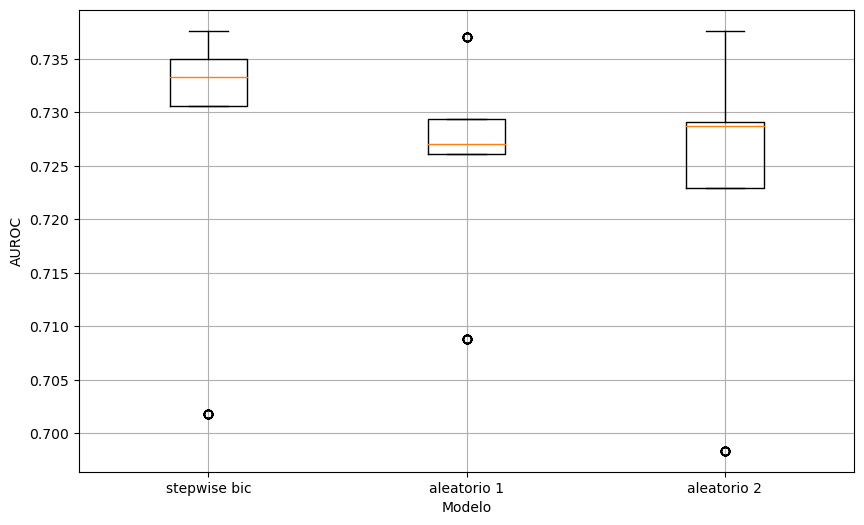

In [46]:
results = pd.DataFrame({
    'Puntuaciones ROC': []
    , 'Resample': []
    , 'Modelo': []
})
for rep in range(20):
    modelo1 = validacion_cruzada_glm(
        5
        , izquierda_predictoras_train
        , izquierda_objetivo_train
        , glm_izquierda_stepwise_bic['Variables']['cont']
        , glm_izquierda_stepwise_bic['Variables']['categ']
        , glm_izquierda_stepwise_bic['Variables']['inter']
    )
    modelo2 = validacion_cruzada_glm(
        5
        , izquierda_predictoras_train
        , izquierda_objetivo_train
        , var_1['cont']
        , var_1['categ']
        , var_1['inter']
    )
    modelo3 = validacion_cruzada_glm(
        5
        , izquierda_predictoras_train
        , izquierda_objetivo_train
        , var_2['cont']
        , var_2['categ']
        , var_2['inter']
    )
    
    results_rep = pd.DataFrame({
        'Puntuaciones ROC': modelo1 + modelo2 + modelo3 
        , 'Resample': ['Rep' + str((rep + 1))]*5*3
        , 'Modelo': [1]*5 + [2]*5 + [3]*5 
    })
    results = pd.concat([results, results_rep], axis = 0)


plt.figure(figsize=(10, 6)) 
plt.grid(True)  

grupo_metrica = results.groupby('Modelo')['Puntuaciones ROC']
boxplot_data = [grupo_metrica.get_group(grupo).tolist() for grupo in grupo_metrica.groups]

model_labels = ["stepwise bic", "aleatorio 1", "aleatorio 2"]
plt.boxplot(boxplot_data, labels=model_labels)

plt.xlabel('Modelo')  
plt.ylabel('AUROC')  
plt.show() 


Seleccionamos como modelo ganador a el obtenido por <b>el metodo de seleccion clasica de variables stepwise siguiendo el criterio BIC </b> al ser el que tiene el pseudo r cuadrado mas alto de los tres

<h3> Evaluacion del modelo ganador </h3>

In [55]:
print('Pseudo R² de train: '+str(pseudoR2(glm_izquierda_stepwise_bic['Modelo'],glm_izquierda_stepwise_bic['X'],izquierda_objetivo_train)))
print("Pseudo R² de test: "+str(pseudoR2(glm_izquierda_stepwise_bic['Modelo'],data_glm_izquierda_stepwise_bic,izquierda_objetivo_test)))
print("nro de parametros: "+ str(len(glm_izquierda_stepwise_bic["Modelo"].coef_[0])))

Optimization terminated successfully.
         Current function value: 0.532797
         Iterations 5
Pseudo R² de train: 0.12219633461816182
Optimization terminated successfully.
         Current function value: 0.521175
         Iterations 5
Pseudo R² de test: 0.14235332598292294
nro de parametros: 23


El pseudoR2 es elevado y se corresponse con el AUROC que tambien es elevado. por lo que podemos decir que estamos frente a un modelo que (al menos frente a los datos de test) demuestra tener una buena capacidad predictiva.

<h4> Obtener punto de corte optimo para el modelo ganador</h4>

Vamos a obtener el mejor punto de corte para el modelo ganador de manera tal que maximicemos la sensibilidad y la especificidad del mismo, usaremos el indice de Youden para obtener la mejor rejilla de punto de corte

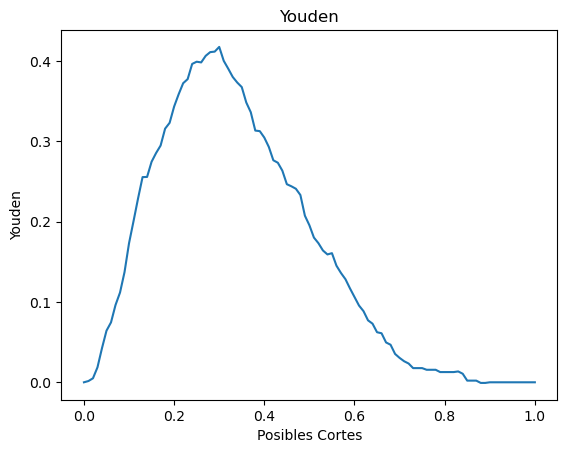

Punto de corte optimo para el modelo de regresion logistica ganador: 0.3


In [64]:
#Generamos una rejilla de puntos de corte
posiblesCortes = np.arange(0, 1.01, 0.01).tolist()  # Generamos puntos de corte de 0 a 1 con intervalo de 0.01
rejilla = pd.DataFrame({
    'PtoCorte': [],
    'Accuracy': [],
    'Sensitivity': [],
    'Specificity': [],
    'PosPredValue': [],
    'NegPredValue': []
})  # Creamos un DataFrame para almacenar las métricas para cada punto de corte

for pto_corte in posiblesCortes:  # Iteramos sobre los puntos de corte
    rejilla = pd.concat(
        [rejilla, sensEspCorte(glm_izquierda_stepwise_bic['Modelo'], izquierda_predictoras_test, izquierda_objetivo_test, pto_corte,
         glm_izquierda_stepwise_bic['Variables']['cont'], glm_izquierda_stepwise_bic['Variables']['categ'])],
        axis=0
    )  # Calculamos las métricas para el punto de corte actual y lo agregamos al DataFrame

rejilla['Youden'] = rejilla['Sensitivity'] + rejilla['Specificity'] - 1  # Calculamos el índice de Youden
rejilla.index = list(range(len(rejilla)))  # Reindexamos el DataFrame para que los índices sean consecutivos



plt.plot(rejilla['PtoCorte'], rejilla['Youden'])
plt.xlabel('Posibles Cortes')
plt.ylabel('Youden')
plt.title('Youden')
plt.show()

print("Punto de corte optimo para el modelo de regresion logistica ganador: "+ str(rejilla['PtoCorte'][rejilla['Youden'].idxmax()]))


Evaluamos el modelo en el punto optimo de corte optimo que hallamos anteriormente, comparamos el desmpeño del mismo con los conjuntos de datos de test y train.

In [67]:
print(sensEspCorte(glm_izquierda_stepwise_bic['Modelo'], izquierda_predictoras_train, izquierda_objetivo_train, 0.3, glm_izquierda_stepwise_bic['Variables']['cont'], glm_izquierda_stepwise_bic['Variables']['categ']))
print(sensEspCorte(glm_izquierda_stepwise_bic['Modelo'], izquierda_predictoras_test, izquierda_objetivo_test, 0.3, glm_izquierda_stepwise_bic['Variables']['cont'], glm_izquierda_stepwise_bic['Variables']['categ']))

   PtoCorte  Accuracy  Sensitivity  Specificity  PosPredValue  NegPredValue
0       0.3  0.757123     0.516107     0.826977       0.46367      0.855001
   PtoCorte  Accuracy  Sensitivity  Specificity  PosPredValue  NegPredValue
0       0.3  0.785099     0.574286     0.843014      0.501247      0.878168


Las medidas de rendimiento se muestran estables entre los conjunto de datos de prueba y entrenamiento. El modelo presenta un sensibilidad buena y una especificdad destacable dando como resultado un modelo con una buena performance y del que se puede esperar que sea consistente a futuro debido a su buen rendimiento con el conjunto de pruebas.

Poniendo en contezto con la variable objetivo nuestro modelo demuestra una capacidad moderada de  identificar correctamente aquellos casos en los que la suma de votos de izquierdas es superior a la de derechas y otros (sensibilidad) y una destacable capacidad de identificar correctamente aquellos casos en los que la suma de votos de derechas y otros es superior a la de izquierdas (especificidad)

<h3>Descripcion del modelo ganador</h3>

Veamos los coeficientes del modelo para poder interpretarlo

In [ ]:

coeficientes = glm_izquierda_stepwise_bic['Modelo'].coef_
nombres_caracteristicas = crear_data_modelo(izquierda_predictoras_train, glm_izquierda_stepwise_bic['Variables']['cont'], glm_izquierda_stepwise_bic['Variables']['categ']).columns  # Suponiendo que X_train es un DataFrame de pandas

for nombre, coef in zip(nombres_caracteristicas, coeficientes[0]):
    print(f"Variable: {nombre}, Coeficiente: {coef}")


Variable: UnemployLess25_Ptge, Coeficiente: 0.03656574929793677
Variable: AgricultureUnemploymentPtge, Coeficiente: 0.031387029661939986
Variable: SameComAutonDiffProvPtge, Coeficiente: -0.06500168950437221
Variable: ForeignersPtge, Coeficiente: -0.030974234692187536
Variable: Age_19_65_pct, Coeficiente: 0.05021245274391037
Variable: SUPERFICIE, Coeficiente: 1.482435709288962e-05
Variable: DifComAutonPtge, Coeficiente: 0.044132743623585866
Variable: IndustryUnemploymentPtge, Coeficiente: -0.020698755643294604
Variable: Explotaciones, Coeficiente: 0.0012097063221796864
Variable: ConstructionUnemploymentPtge, Coeficiente: 0.008961749639822445
Variable: PobChange_pct, Coeficiente: -0.01192603960223333
Variable: Age_under19_Ptge, Coeficiente: 0.048916153621468395
Variable: Age_0-4_Ptge, Coeficiente: -0.1201125242288002
Variable: Unemploy25_40_Ptge, Coeficiente: 0.004472435710327706
Variable: AbstentionPtge, Coeficiente: 0.011678443342330558
Variable: SameComAutonPtge, Coeficiente: 0.018101

Tomemos una varaible predictora categorica y una numerica e interpretemos sus coeficientes:

<li>UnemployLess25_Ptge: esta variable tiene un  coeficiente positivo de ~ 0.036 sugiere que un aumento en el porcentaje de desempleados menores de 25 años está asociado con un aumento en la probabilidad de que la suma de votos de izquierdas sea superior a la de derechas.</li>
<br>
<li>ActividadPpal: todos los coefieicentes de las variables dummy de actividad principal son negativos por lo que sugieren que estas acividades  están asociadas con una disminución en la probabilidad de que la suma de votos de izquierdas sea superior a la de derechas. </li>